In [1]:
# Imports and hyperparams
%matplotlib inline
import os
import cv2
import numpy as np
import scipy.io as sio
from DenseDepthModel import DenseDepth
from DORN import DORN
from MiDaSModel import get_midas, midas_predict
from capture_utils import loadmat_h5py, z_to_r_kinect, r_to_z_kinect, rescale_bins, normals_from_depth
from models.data.data_utils.sid_utils import SID
from remove_dc_from_spad import remove_dc_from_spad_edge
from weighted_histogram_matching import image_histogram_match
# from spad_utils import rescale_bins
import h5py
import matplotlib.pyplot as plt
rootdir = "data/8_30_conference_room2_scene"

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

loaded_orig = False

Using TensorFlow backend.


No relevant file, loading original from data/8_30_conference_room2_scene/spad/data_accum.mat


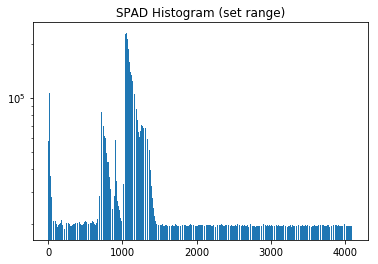

In [3]:
# Load SPAD data
relevant_file = os.path.join(rootdir, "spad_relevant.npy")
force_refresh = False
if os.path.isfile(relevant_file) and not force_refresh:
    print("Loading from {}".format(relevant_file))
    spad_relevant_dict = np.load(relevant_file, allow_pickle=True)
    spad_relevant = spad_relevant_dict["spad_relevant"]
    min_depth_bin = spad_relevant_dict["min_depth_bin"]
    max_depth_bin = spad_relevant_dict["max_depth_bin"]
else:
    orig_file = os.path.join(rootdir, "spad", "data_accum.mat")
    print("No relevant file, loading original from {}".format(orig_file))
    spad = loadmat_h5py(orig_file)
    # No relevant file yet, so plotting:
    spad_single = np.sum(spad["mat"], axis=(0,1))
    plt.bar(range(len(spad_single)), spad_single, log=True)
    plt.title("SPAD Histogram (set range)")
    loaded_orig = True
#     spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
#     np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant)


min depth, max_depth
1.2384 4.0008
516 1666


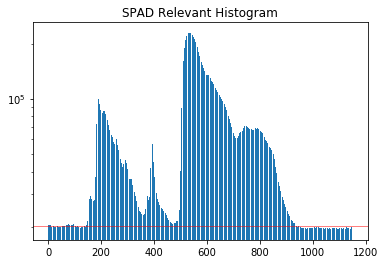

In [9]:
# Inspect SPAD, set min and max depths, and set the ambient estimate
# Extract relevant subset of SPAD and save
bin_width_ps = 16  # Bin width is 16 ps
bin_width_m = bin_width_ps*3e8/(2*1e12)
if loaded_orig:
    # Adjust parameters here
    min_depth_bin = 516
    max_depth_bin = 1666
    spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
    spad_relevant_dict = {
        "spad_relevant": spad_relevant,
        "min_depth_bin": min_depth_bin,
        "max_depth_bin": max_depth_bin
    }
    np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant_dict)
min_depth = min_depth_bin*bin_width_m
max_depth = (max_depth_bin+1)*bin_width_m
print("min depth, max_depth")
print(min_depth, max_depth)
print(min_depth_bin, max_depth_bin)
    
# Plot to visualize the clipping
spad_single_relevant = np.sum(spad_relevant, axis=(0,1))
plt.bar(range(len(spad_single_relevant)), spad_single_relevant, log=True)
plt.title("SPAD Relevant Histogram")

# Estimate ambient level:
ambient_max_depth = 100
ambient_estimate = np.mean(spad_single_relevant[:ambient_max_depth])
plt.axhline(y=ambient_estimate, color='r', linewidth=0.5)


(3, 510, 510)


Text(0.5, 1.0, 'Normal component')

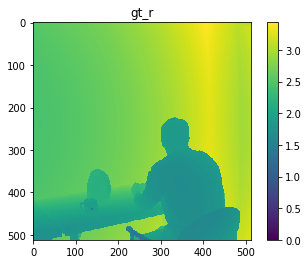

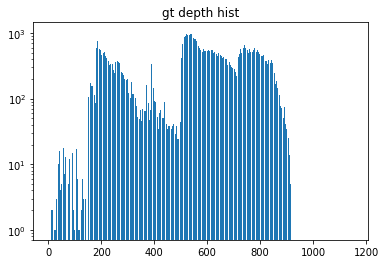

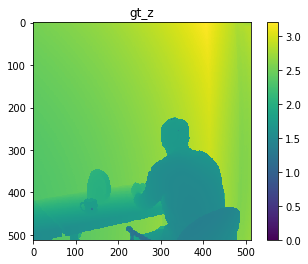

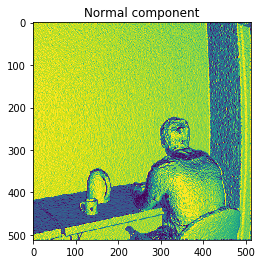

In [64]:
# Get Ground truth depth
import scipy.signal as signal
gt_idx = np.argmax(spad_relevant, axis=2)
gt_r = signal.medfilt(np.fliplr(np.flipud(((gt_idx + min_depth_bin) * bin_width_m).T)), kernel_size=5)
plt.figure()
plt.imshow(gt_r)
plt.title("gt_r")
plt.colorbar()

gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist, log=True)
plt.title("gt depth hist")

gt_z = r_to_z_kinect(gt_r)
plt.figure()
plt.imshow(gt_z)
plt.colorbar()
plt.title("gt_z")

# Extract surface normals and compute new weights
gt_n = normals_from_depth(gt_r)
print(gt_n.shape)
normals = np.zeros((gt_n.shape[1]+2, gt_n.shape[2]+2))
normals[1:-1, 1:-1] = gt_n[2,...]
plt.figure()
plt.imshow(normal_weights, vmin=0., vmax=1.)
plt.title("Normal component")




[   0.          5.532654   11.095032   16.687317   22.30951    27.961853
   33.644592   39.357788   45.101685   50.876343   56.682007   62.51892
   68.38696    74.28656    80.217834   86.18103    92.17609    98.20337
  104.263     110.35504   116.47986   122.637695  128.82843   135.0523
  141.30963   147.60046   153.92517   160.28375   166.67645   173.10352
  179.56506   186.06134   192.59229   199.15839   205.7597    212.39636
  219.06879   225.77698   232.52124   239.30145   246.11823   252.97144
  259.86157   266.7885    273.75275   280.7542    287.79358   294.87042
  301.98535   309.1383    316.32983   323.55988   330.82855   338.1366
  345.48346   352.87006   360.29608   367.7621    375.26813   382.81433
  390.40106   398.0285    405.69714   413.40643   421.15753   428.95007
  436.7843    444.66064   452.57928   460.54047   468.54425   476.59113
  484.6811    492.81445   500.99146   509.21234   517.4775    525.78656
  534.1408    542.53925   550.9832    559.47235   568.007     576

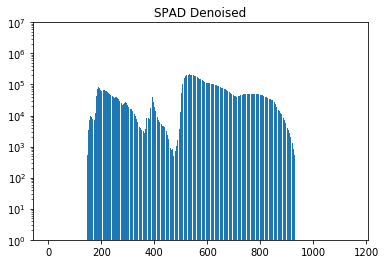

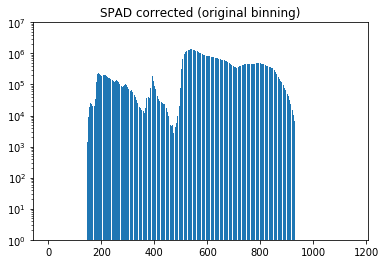

<Figure size 432x288 with 0 Axes>

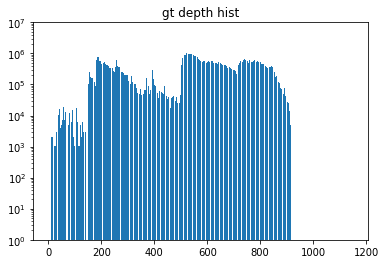

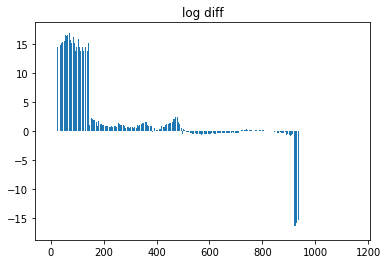

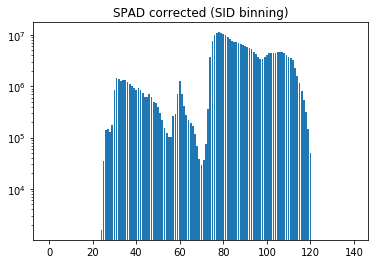

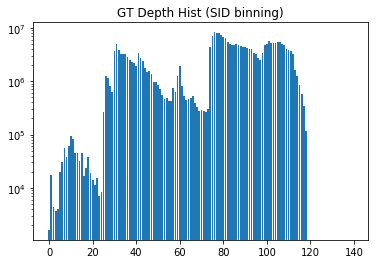

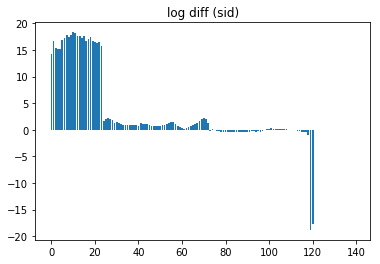

In [77]:
# Preprocess SPAD
sid_obj = SID(sid_bins=140, alpha=min_depth, beta=max_depth, offset=min_depth)

vmin = 1e0
vmax = 1e7

# Remove DC
spad_denoised = remove_dc_from_spad_edge(spad_single_relevant, ambient_estimate)
plt.figure()
plt.bar(range(len(spad_denoised)), spad_denoised, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD Denoised")

# Correct Falloff
bin_edges = np.linspace(min_depth, max_depth, len(spad_denoised) + 1)
bin_values = (bin_edges[1:] + bin_edges[:-1])/2
spad_corrected = spad_denoised * bin_values ** 2
plt.figure()
plt.bar(range(len(spad_corrected)), spad_corrected, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD corrected (original binning)")

# GT Depth Histogram for reference
gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
gt_r_hist_scaled = gt_r_hist * np.sum(spad_corrected)/np.sum(gt_r_hist)
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist_scaled, log=True)
plt.ylim(vmin, vmax)
plt.title("gt depth hist")

# Log difference plot for reference:
log_diff = np.log(gt_r_hist_scaled+1e-3) - np.log(spad_corrected+1e-3)
plt.figure()
plt.bar(range(len(log_diff)), log_diff)
plt.title("log diff")

# Convert to SID
spad_sid = rescale_bins(spad_corrected, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(spad_sid)), spad_sid, log=True)
plt.title("SPAD corrected (SID binning)");

# GT Depth SID Histogram for reference
gt_r_hist_sid = rescale_bins(gt_r_hist_scaled, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(gt_r_hist_sid)), gt_r_hist_sid, log=True)
plt.title("GT Depth Hist (SID binning)");

# Log diff sid
log_diff_sid = np.log(gt_r_hist_sid + 1e-3) - np.log(spad_sid + 1e-3)
plt.figure()
plt.bar(range(len(log_diff_sid)), log_diff_sid)
plt.title("log diff (sid)");



In [79]:
print(log_diff_sid[-30:])

[  0.03463657   0.03845895   0.01906187  -0.31396484  -0.27666203
  -0.32225194  -0.33705734  -0.46492461  -0.9868971  -18.81846764
 -17.70909245   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]


Loading calibration data...
Loading kinect data...
0
0


(-0.5, 863.5, 767.5, -0.5)

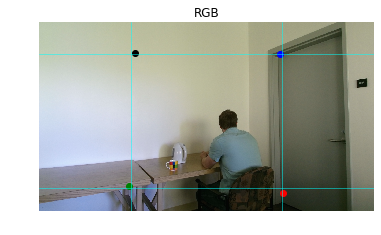

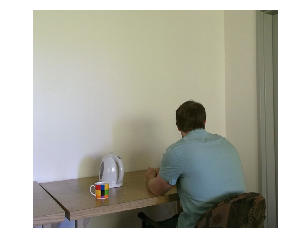

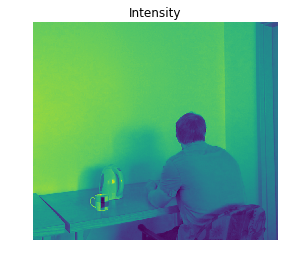

In [57]:
# RGB Images
# Calibration data
print("Loading calibration data...")
calib = loadmat_h5py(os.path.join(rootdir, "calibration.mat"))

print("Loading kinect data...")
kinect = loadmat_h5py(os.path.join(rootdir, "kinect.mat"))
# Transpose and visualize
plt.figure()
kinect_rgb = np.fliplr(kinect["rgb_im"].transpose(2, 1, 0))
plt.imshow(kinect_rgb)
plt.title("RGB")
plt.axis("off")
plt.plot(calib["pos_00"][1], calib["pos_00"][0], "ro")
plt.plot(calib["pos_01"][1], calib["pos_01"][0], "bo")
plt.plot(calib["pos_10"][1], calib["pos_10"][0], "go")
plt.plot(calib["pos_11"][1], calib["pos_11"][0], "ko")

# print(calib["pos_00"]) # position 0 is the row, position 1 is the column
# Extract crop
top = (calib["pos_01"][0] + calib["pos_11"][0])//2
bot = (calib["pos_10"][0] + calib["pos_00"][0])//2
left = (calib["pos_11"][1] + calib["pos_10"][1])//2
right = (calib["pos_01"][1] + calib["pos_00"][1])//2

# Scene-specific crop
crop = (int(top[0])+6, int(bot[0])-6, int(left[0])-4, int(right[0])+3)
print((crop[1] - crop[0]) % 32)
print((crop[3] - crop[2]) % 32)
plt.axhline(y=crop[0], color='cyan', linewidth=0.5)
plt.axhline(y=crop[1], color='cyan', linewidth=0.5)
plt.axvline(x=crop[2], color='cyan', linewidth=0.5)
plt.axvline(x=crop[3], color='cyan', linewidth=0.5)

# Kinect Depth - don't use for now
# plt.figure()
# kinect_depth = np.fliplr(kinect["depth_im"].transpose(1, 0))
# plt.imshow(kinect_depth)
# plt.title("Kinect Depth")
# plt.axis("off");

# Crop
rgb_cropped = kinect_rgb[crop[0]:crop[1], crop[2]:crop[3], :]
plt.figure()
plt.imshow(rgb_cropped)
plt.axis("off")

# Intensity
intensity = rgb_cropped[:,:,0]/225.
plt.figure()
plt.imshow(intensity)
plt.title("Intensity")
plt.axis("off")

0.9005495338521979
0.32200774576396407
0.8977777777777778
0.8711111111111111


ValueError: operands could not be broadcast together with shapes (512,512) (768,864) 

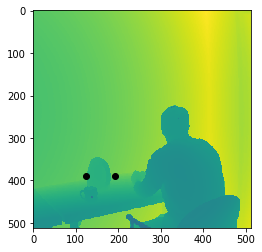

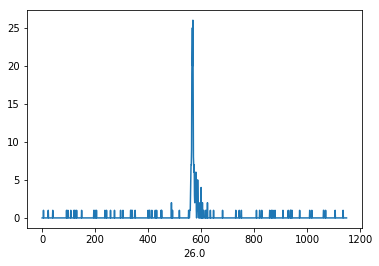

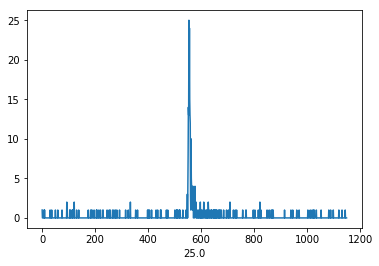

In [58]:
# Investigate two points with same depth but different angles
# plt.plot(gt_r[390,:250])
plt.imshow(gt_r)

pt1 = (390, 125) # (Y, X)
pt2 = (390, 192)

plt.plot(pt1[1], pt1[0], "ko")
plt.plot(pt2[1], pt2[0], "ko")

hist1 = spad_relevant[pt1[0], pt1[1], :]
hist2 = spad_relevant[pt2[0], pt2[1], :]

plt.figure()
plt.plot(hist1)
plt.xlabel(np.max(hist1))

plt.figure()
plt.plot(hist2)
plt.xlabel(np.max(hist2))

print(normal_weights[pt1[0], pt1[1]])
print(normal_weights[pt2[0], pt2[1]])

print(intensity[pt1[0], pt1[1]])
print(intensity[pt2[0], pt2[1]])

weight = normal_weights*intensity
print(weight[pt1[0], pt1[1]])
print(weight[pt2[0], pt2[1]])

print(np.sum(hist1)/np.sum(hist2))

# print(gt_r[390, :250])
# print(gt_r[390, 125])
# print(gt_r[390, 192])

Text(0.5, 1.0, 'r_init')

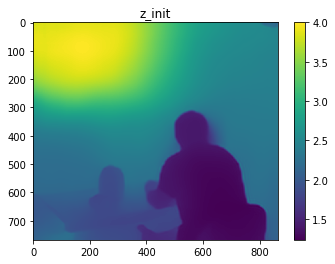

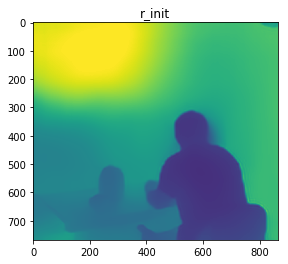

In [61]:
# Run RGB through CNN
midas_model = get_midas(model_path="MiDaS/model.pt", device="cpu")
z_init = midas_predict(midas_model, rgb_cropped/255., depth_range=(min_depth, max_depth), device="cpu")
plt.figure()
plt.imshow(z_init, vmin=min_depth, vmax=max_depth)
plt.title("z_init")
plt.colorbar()

# Convert to radial distance
r_init = z_to_r_kinect(z_init)
plt.figure()
plt.imshow(r_init, vmin=min_depth, vmax=max_depth)
plt.title("r_init")


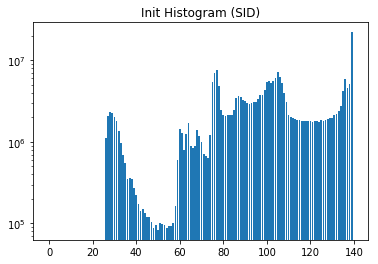

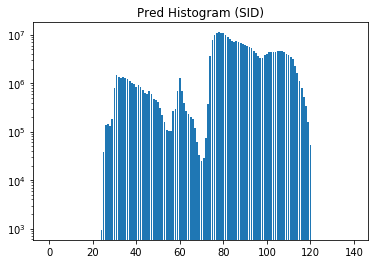

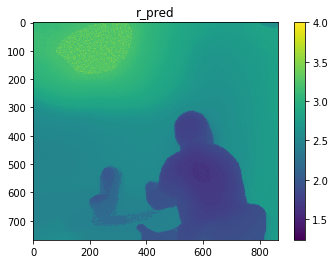

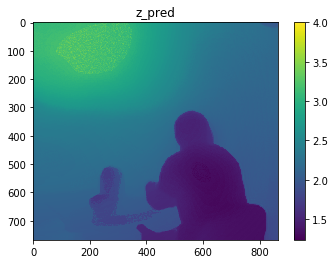

In [70]:
# Histogram match r_init to spad corrected sid
# Perform histogram matching
weights = intensity * cv2.resize(normals, (intensity.shape[1], intensity.shape[0]))
r_pred, t = image_histogram_match(r_init, spad_sid, weights, sid_obj)
init_hist = t[1]
pred_hist = t[3]
z_pred = r_to_z_kinect(r_pred)
# r_pred, _ = image_histogram_match(r_init, spad_sid, np.ones_like(r_init), sid_obj)
plt.figure()
plt.bar(range(len(init_hist)), init_hist, log=True)
plt.title("Init Histogram (SID)")
plt.figure()
plt.bar(range(len(pred_hist)), pred_hist, log=True)
plt.title("Pred Histogram (SID)")
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")
plt.colorbar()
plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("z_pred")
plt.colorbar()


[   0.          5.532654   11.095032   16.687317   22.30951    27.961853
   33.644592   39.357788   45.101685   50.876343   56.682007   62.51892
   68.38696    74.28656    80.217834   86.18103    92.17609    98.20337
  104.263     110.35504   116.47986   122.637695  128.82843   135.0523
  141.30963   147.60046   153.92517   160.28375   166.67645   173.10352
  179.56506   186.06134   192.59229   199.15839   205.7597    212.39636
  219.06879   225.77698   232.52124   239.30145   246.11823   252.97144
  259.86157   266.7885    273.75275   280.7542    287.79358   294.87042
  301.98535   309.1383    316.32983   323.55988   330.82855   338.1366
  345.48346   352.87006   360.29608   367.7621    375.26813   382.81433
  390.40106   398.0285    405.69714   413.40643   421.15753   428.95007
  436.7843    444.66064   452.57928   460.54047   468.54425   476.59113
  484.6811    492.81445   500.99146   509.21234   517.4775    525.78656
  534.1408    542.53925   550.9832    559.47235   568.007     576

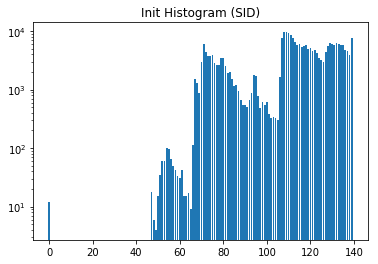

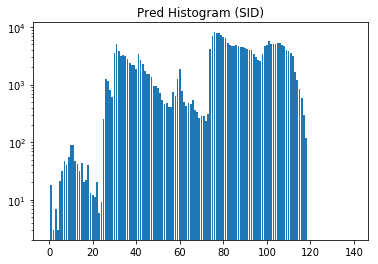

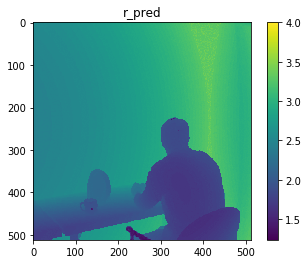

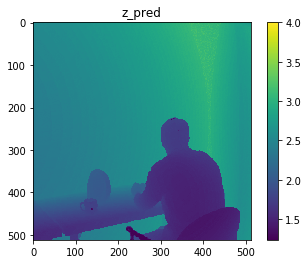

In [76]:
# Try Histogram matching a shifted version of ground truth.
# Histogram match r_init to spad corrected sid
# Perform histogram matching
weights = intensity * cv2.resize(normals, (intensity.shape[1], intensity.shape[0]))
gt_r_hist_sid = rescale_bins(gt_r_hist, min_depth, max_depth, sid_obj)
r_pred, t = image_histogram_match(gt_r + 0.7, gt_r_hist_sid, np.ones_like(gt_r), sid_obj)
init_hist = t[1]
pred_hist = t[3]
z_pred = r_to_z_kinect(r_pred)
# r_pred, _ = image_histogram_match(r_init, spad_sid, np.ones_like(r_init), sid_obj)
plt.figure()
plt.bar(range(len(init_hist)), init_hist, log=True)
plt.title("Init Histogram (SID)")
plt.figure()
plt.bar(range(len(pred_hist)), pred_hist, log=True)
plt.title("Pred Histogram (SID)")
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")
plt.colorbar()
plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("z_pred")
plt.colorbar()